# BT Neural Network for option price in BS model

В этой версии нейронной сети попробуем сделать слои плотными...

In [4]:
!pip install matplotlib scipy 

  Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached scipy-1.17.0-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-macosx_10_13_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached scipy-1.17.0-cp313-cp313-macosx_14_0_arm64.whl (20.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-cp313-macosx_10_13_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib] 6/7 [matplotlib]


In [5]:
import tensorflow as tf
import numpy as np
import scipy.stats as spstats
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import warnings
# warnings.simplefilter("ignore")
# from tensorflow.python.util import deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.__version__

'2.20.0'

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, use
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [7]:
# Mac OS specific - to prevent Error #15: Initializing libiomp5.dylib, 
# but found libiomp5.dylib already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [8]:
# set to physical core count
# tf.config.threading.set_intra_op_parallelism_threads(8)
# tf.config.threading.set_inter_op_parallelism_threads(8)

In [9]:
# NB это не нейросеть, а движок для вычисления цен опционов!
class MyIBT_CRR():
    def __init__(self, n):
        self.n     = n     # number of levels
        self.S_    = np.zeros(shape=(int((n+1)*(n+2)/2),),dtype=np.float32)   
        self.q_    = np.zeros(shape=(int((n+1)*(n+2)/2),),dtype=np.float32)
        self.V_    = np.zeros(shape=(int((n+1)*(n+2)/2),),dtype=np.float32)
    
    def _setS(self, i, j, val):
        self.S_[int(i*(i + 1)/2) + j] = val

    def _getS(self, i, j):
        return self.S_[int(i*(i + 1)/2) + j]

    def _setq(self, i, j, val):
        self.q_[int(i*(i + 1)/2) + j] = val

    def _getq(self, i, j):
        return self.q_[int(i*(i + 1)/2) + j]

    def _setV(self, i, j, val):
        self.V_[int(i*(i + 1)/2) + j] = val

    def _getV(self, i, j):
        return self.V_[int(i*(i + 1)/2) + j]

    def build(self, S0, t0, T, r, sigma, teta):
        # self.S0    = S0    # current price
        self.t0    = t0    # current time
        self.T     = T     # maturity time
        self.r     = r     # interest rate
        # self.sigma = sigma # volatility function (constant)

        dt = (T - t0)/self.n
        sqdt = np.sqrt(dt)
        
        # starting from even levels, identified by k
        for k in range((self.n // 2) + 1):
            # central node on even levels
            self._setS(2*k, k, S0)
            
            for j in range(1, self.n - 2*k + 1): # 2*k+j<=n
                t_ = t0 + (2*k+j-1)*dt
                self._setS(2*k+j, k,  self._getS(2*k+j-1, k)*
                           np.exp(-sigma(self._getS(2*k+j-1, k), t_, teta)*sqdt))
                self._setS(2*k+j, k+j, self._getS(2*k+j-1, k+j-1)*
                           np.exp(sigma(self._getS(2*k+j-1, k+j-1), t_, teta)*sqdt))

        # The probabilities of transition from node (i,j) to node (i+1,j+1)
        for i in range(self.n):
            for j in range(i+1):
                self._setq(i, j, (self._getS(i, j)*np.exp(r*dt)-self._getS(i+1, j))/
                          (self._getS(i+1, j+1)-self._getS(i+1, j))
                )

    def evalEurCall(self, K):
        # K is strike-price of a European call option
        dt = (self.T - self.t0)/self.n
        
        # option values at expiration
        for j in range(self.n + 1):
            self._setV(self.n, j, max(self._getS(self.n, j) - K, 0))
            
        # option values before expiration
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                self._setV(i, j, np.exp(-self.r*dt)*(
                    self._getV(i + 1, j + 1)*self._getq(i, j) + 
                    self._getV(i + 1, j)*(1 - self._getq(i, j))
                ))
                
        return self._getV(0, 0)
    
    def evalAmerCall(self, K):
        # K is strike-price of an American call option
        dt = (self.T - self.t0)/self.n
        
        # option values at expiration
        for j in range(self.n + 1):
            self._setV(self.n, j, max(self._getS(self.n, j) - K, 0))
            
        # option values before expiration
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                self._setV(i, j, max(np.exp(-self.r*dt)*(
                    self._getV(i + 1, j + 1)*self._getq(i, j) + 
                    self._getV(i + 1, j)*(1 - self._getq(i, j))
                ),  self._getS(i, j) - K))
                
        return self._getV(0, 0)
    
    def evalEurPut(self, K):
        # K is strike-price of a European put option
        dt = (self.T - self.t0)/self.n
        
        # option values at expiration
        for j in range(self.n + 1):
            self._setV(self.n, j, max(K - self._getS(self.n, j), 0))
            
        # option values before expiration
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                self._setV(i, j, np.exp(-self.r*dt)*(
                    self._getV(i + 1, j + 1)*self._getq(i, j) + 
                    self._getV(i + 1, j)*(1 - self._getq(i, j))
                ))
                
        return self._getV(0, 0)

    def evalAmerPut(self, K):
        # K is strike-price of an American put option
        dt = (self.T - self.t0)/self.n
        
        # option values at expiration
        for j in range(self.n + 1):
            self._setV(self.n, j, max(K - self._getS(self.n, j), 0))
            
        # option values before expiration
        for i in range(self.n - 1, -1, -1):
            for j in range(i + 1):
                self._setV(i, j, max(np.exp(-self.r*dt)*(
                    self._getV(i + 1, j + 1)*self._getq(i, j) + 
                    self._getV(i + 1, j)*(1 - self._getq(i, j))
                ), K - self._getS(i, j)))
                
        return self._getV(0, 0)

    def plot(self):
        # plot Sij on plane (t,S)
        x_lst = []
        y_lst = []
        dt = (self.T - self.t0)/self.n
        for i in range(self.n):
            t_ = self.t0 + (i-1)*dt
            for j in range(i+1):
                x_lst.append(t_)
                y_lst.append(self._getS(i, j))
        
        plt.figure()
        plt.figure(figsize = (8,6))

        plt.scatter(x_lst, y_lst, c="red")

        # plot options
        plt.title("IBT Nodes", fontsize=20)
        plt.ylabel(r"Price $S$", fontsize=15, labelpad=10)
        plt.xlabel(r"Time $t$", fontsize=15, labelpad=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

    @property
    def min(self):
        return self._getS(self.n, 0)

    @property
    def max(self):
        return self._getS(self.n, self.n)

In [10]:
##%% convolution layer used in BTNN - modification of Keras layer class

#W_init = tf.random_uniform_initializer()

class ConvLayer(tf.keras.layers.Layer):
    #W_conv = tf.Variable(
    #    initial_value=W_init(shape=(2,1,1), dtype='float32'),
    #    trainable=True)
    #self._trainable_weights.append(W_conv)
    
    # constructor/initializer function 
    def __init__(self):
        '''
        Args:
            N/A
        
        Returns: customized Keras layer object used as intermediate layers in BTNN
        '''
        
        # create an instance of a Layer object 
        super(ConvLayer, self).__init__()
        
        # add properties for layer 
        self.W_conv = self.add_weight(name='W_conv', 
                            shape=(2,1,1),
                            dtype='float64',    
                            initializer='uniform',
                            trainable=True)

                           
    # main function to be called
    def call(self, X):
        '''Compute output of a ConvLayer for a given inputs X .
        Args:
            X: output of previous layer
        
        Returns: output of layer object 
        '''
        
        # reshape input data
        data  = tf.reshape(X, [X.shape[0], X.shape[1], 1])
        
        # compute components of Conv layer output 
        X_new = tf.squeeze(tf.nn.conv1d(data, self.W_conv, 1, 'VALID'))
        # print(X_new.shape)
        return X_new


In [11]:
##%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function 
    def __init__(self, input_dim, output_dim, W=None, bias=None, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map
        
        Returns: customized Keras (fully connected) layer object
        '''
        
        # create an instance of a Layer object 
        super(DenseLayer,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        if W is None:
            self.W = self.add_weight(name = "W", shape=(self.input_dim, self.output_dim),
                                     dtype=tf.float64,
                                     initializer=tf.initializers.glorot_uniform())
        else:            
            self.W = tf.constant(W, dtype = tf.float64)
        #self.W = tf.Variable( 
        #    np.ones(shape=[self.input_dim, self.output_dim], dtype='float32'),
        #    trainable=True)
        
        # bias vectors
        if bias is None:
            self.b = tf.constant(np.zeros(shape=[1, output_dim]))
        else:
            self.b = tf.constant(bias)
        #self.b = self.add_weight("b", shape=[1, self.output_dim])
        #self.b = tf.Variable(
        #    np.array([S0*np.exp(sig*np.sqrt((T-t0)/n_dim)*(2*j-n_dim)) 
        #              for j in range(self.output_dim)], dtype='float32').reshape(1,-1),
        #    trainable=True)         
            
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called
    def call(self,X):
        '''Compute output of a dense layer for a given input X
        Args:
            X: input to layer
        '''
        
        # compute dense layer output
        # print('X->',X.dtype,' W->',self.W.dtype,' b->',self.b.dtype)
        res = tf.cast(tf.add(tf.matmul(X, self.W), self.b), dtype = tf.float64)
        # res = tf.add(tf.matmul(self.W X), self.b)
                
        if self.transformation:
            res = self.transformation(res)

        print(res.shape)
        
        return res


In [12]:
##%% Neural network architecture with BT - modification of Keras Model class
    
class BTNet(tf.keras.Model):
    
    # constructor/initializer function 
    def __init__(self, n_dim):
        '''
        Args:
            n_dim:       number of time periods
        
        Returns: customized Keras model object representing BT neural network
        '''
        
        # create an instance of a Model object
        super(BTNet,self).__init__()
        
        # define initial layer as fully connected
        W = np.ones(shape=[1, n_dim + 1])
        b = np.array([-S0*np.exp(sig*np.sqrt((T-t0)/n_dim)*(2*j-n_dim)) 
                      # 
            for j in range(n_dim + 1)]).reshape(1,-1) # , dtype=np.float32
        self.initial_layer = DenseLayer(1, n_dim + 1, W, b, transformation = "relu")
        
        # define intermediate convolution layers
        self.n_layers = n_dim
        self.hidden_layer = ConvLayer()
        
        self.LayerList = []


    
        # self.LayerList.append(DenseLayer(n_dim + 1, n_dim))
        for idx in range(self.n_layers):
            self.LayerList.append(DenseLayer(n_dim + 1 - idx, n_dim - idx))    
                            
    
    # main function to be called
    def call(self,K):
        '''
        Args:
            K: sampled strike-price inputs
        Run the BTNN model and obtain fitted function value at the inputs (K)
        '''
        
        # define input vector 
        X = tf.cast(tf.concat([K],1), dtype = tf.float64)
        
        # call initial layer
        X_next = self.initial_layer.call(X)
        #print('X =',X)
        #print('X_next =',X_next)
        
        # call conv layers
        for i in range(self.n_layers):
            #print('-> Слой ', i, end='')
            X_next = self.LayerList[i].call(X_next)

        return X_next


In [13]:
# Option parameters for BS model
r = 0.05           # Interest rate
sig = 0.25         # Volatility parameter
K_min = 0.25       # Min strike price
K_max = 0.75       # Max strike price
t0 = 0.            # initial time
T = 1.             # expiration time (maturity)
S0 = 0.5           # Initial price

In [14]:
# Solution parameters (domain on which to solve PDE)
t_low  = 0.+1e-10  # time lower bound 1e-10
#S_low  = 0.+1e-10  # spot price lower bound 1e-10
#S_high = 2*K_max   # spot price upper bound

In [15]:
# BT model network parameters
r = 0.05           # Interest rate
sig = 0.25         # Volatility parameter
K_min = 0.25       # Min strike price
K_max = 0.75       # Max strike price
t0 = 0.            # initial time
T = 1.             # expiration time (maturity)
S0 = 0.5           # Initial price

In [16]:
# volatility function parameters
pDim = 1
teta = np.array([sig], dtype=np.float64) # , shape=(pDim,)
sigma = lambda S,t,tet: tet[0] 

In [17]:
xIBT.build(S0, t0, T, r, sigma, teta)

In [18]:
# Training parameters
sampling_stages  = 1 # number of times to resample new time-price domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

In [19]:
# Sampling parameters
nK = 500
# nSim_interior = 1000
# nSim_terminal = 100
# S_multiplier  = 1.2   # multiplier for oversampling i.e. draw S from [S_low, S_high * S_multiplier]

In [20]:
# Plot options
n_plot = 51  # Points on plot grid for each dimension

In [21]:
##%% Black-Scholes European put price
def BSEurPut(S, t, K, T, r, sigma):
    ''' Analytical solution for European put option price 
        under Black-Scholes model 
    
    Args:
        S:     spot price
        t:     time
        K:     strike price
        T:     expiration (maturity) time
        r:     risk-free interest rate
        sigma: volatility

    '''
    if T==t:
        callPrice = np.maximum(K - S , np.zeros_like(S))
    else:
        d1 = (np.log(S/K) + (r + sigma**2 / 2) * (T-t))/\
            (sigma * np.sqrt(T-t))
        d2 = d1 - (sigma * np.sqrt(T-t))
        putPrice = -S * spstats.norm.cdf(-d1) + \
            K * np.exp(-r * (T-t)) * spstats.norm.cdf(-d2)
    return putPrice

In [22]:
# %% Sampling function - randomly sample strike-prices
def sampler(nK, K_low, K_high):
    ''' Sample strike-price points from the function's domain; points are sampled
        uniformly on the interior of the domain

    Args:
        nK: number of strike-price points between Kmin and Kmax
  
    '''
    # Sampler 
    K_interior = np.random.uniform(low=K_low, high=K_high, size=[nK, 1])

    return K_interior

In [23]:
# Loss function for BS model in BT approach
def loss(model, t_int, S_int, t_term, S_term, T_s, K_s):
    ''' Compute total loss for training.
    
    Args:
        model:  DGM model object
        t_int:  sampled time points in the interior of the option price domain
        S_int:  sampled price points in the interior of the option price domain
        t_term: sampled time points at expiration (equal to T_s)
        S_term: sampled price points at expiration (at time T_s)
        T_s:    random expiration time (t_int < T_s)
        K_s:    random strike price
    '''
    # Loss term #1: BSM PDE
    # option value and derivatives w.r.t. S and t at sampled points
    with tf.GradientTape() as t_SS:
        with tf.GradientTape() as t_S:
            with tf.GradientTape() as t_t:
                V    = model(t_int, S_int, T_s*np.ones_like(t_int), K_s*np.ones_like(S_int))
            V_t  = t_t.gradient(V, t_int)
        V_s  = t_S.gradient(V, S_int)
    V_ss = t_SS.gradient(V_s, S_int)
    # LVM model dependent code
    diff_V = V_t + 0.5*(lamb**2+2.*r*S_int**2)*V_ss + r*S_int*V_s - r*V

    # average L2-norm of differential operator
    L1 = tf.reduce_mean(tf.square(diff_V)) 
        
    # Loss term #2: terminal condition
    target_payoff = tf.nn.relu(S_term - K_s)
    fitted_payoff = model(t_term, S_term, T_s*np.ones_like(t_term), K_s*np.ones_like(S_term))
    
    L2 = tf.reduce_mean( tf.square(fitted_payoff - target_payoff) )

    return tf.add(L1, L2)

In [24]:
##%% Set up BT network

# initialize BT model 
model = BTNet(n_dim)

In [25]:
# loss function during training
loss_arr = np.zeros((2,sampling_stages))

In [26]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [27]:
import sys
start_time = timer()

best_loss = sys.float_info.max
##%% Train network
# for each sampling stage
for i in range(sampling_stages):
    
    # sample K's 
    K_s = sampler(nK, K_min, K_max)
    K_var = tf.Variable(K_s, dtype = tf.float64) # ,dtype=tf.float32
    print("Sample: ", K_s.shape)
    
    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            # Compute the loss value for this minibatch.
            # loss_value = loss(model, t_int_var, S_int_var, t_term_var, S_term_var, T_s, K_s)
            putBS = BSEurPut(S0, t0, K_var, T, r, sig)
            #print("putBS =", putBS)
            putBT = model(K_var)
            #print("putBT =", putBT)
            loss_value = tf.reduce_mean( tf.square(putBS - putBT) )
            
        #if loss_value.numpy() < best_loss:
        #    model.save('BTNN_model')
        #    print('loss ->',loss_value.numpy(),'-> saving model...')
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
            
    print('{:3} -> {:12.8f}'.format(i, loss_value.numpy())) #,end=' ')
#    print(np.array(model.trainable_weights[0])[0][0][0],', ',
#          np.array(model.trainable_weights[0])[1][0][0])
    #print(np.array(grads))
    loss_arr[0,i] = i
    loss_arr[1,i] = loss_value.numpy()

end_time = timer()
print("Time elapsed:", end_time - start_time) # Time in seconds

Sample:  (500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)
(500, 2)
(500, 1)
(500, 10)
(500, 9)
(500, 8)
(500, 7)
(500, 6)
(500, 5)
(500, 4)
(500, 3)

/opt/homebrew/Caskroom/miniconda/base/envs/btnn-bs/lib/python3.13/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'bt_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/btnn-bs/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['conv_layer/W_conv'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


In [28]:
#model = tf.keras.saving.load_model('BTNN_model')

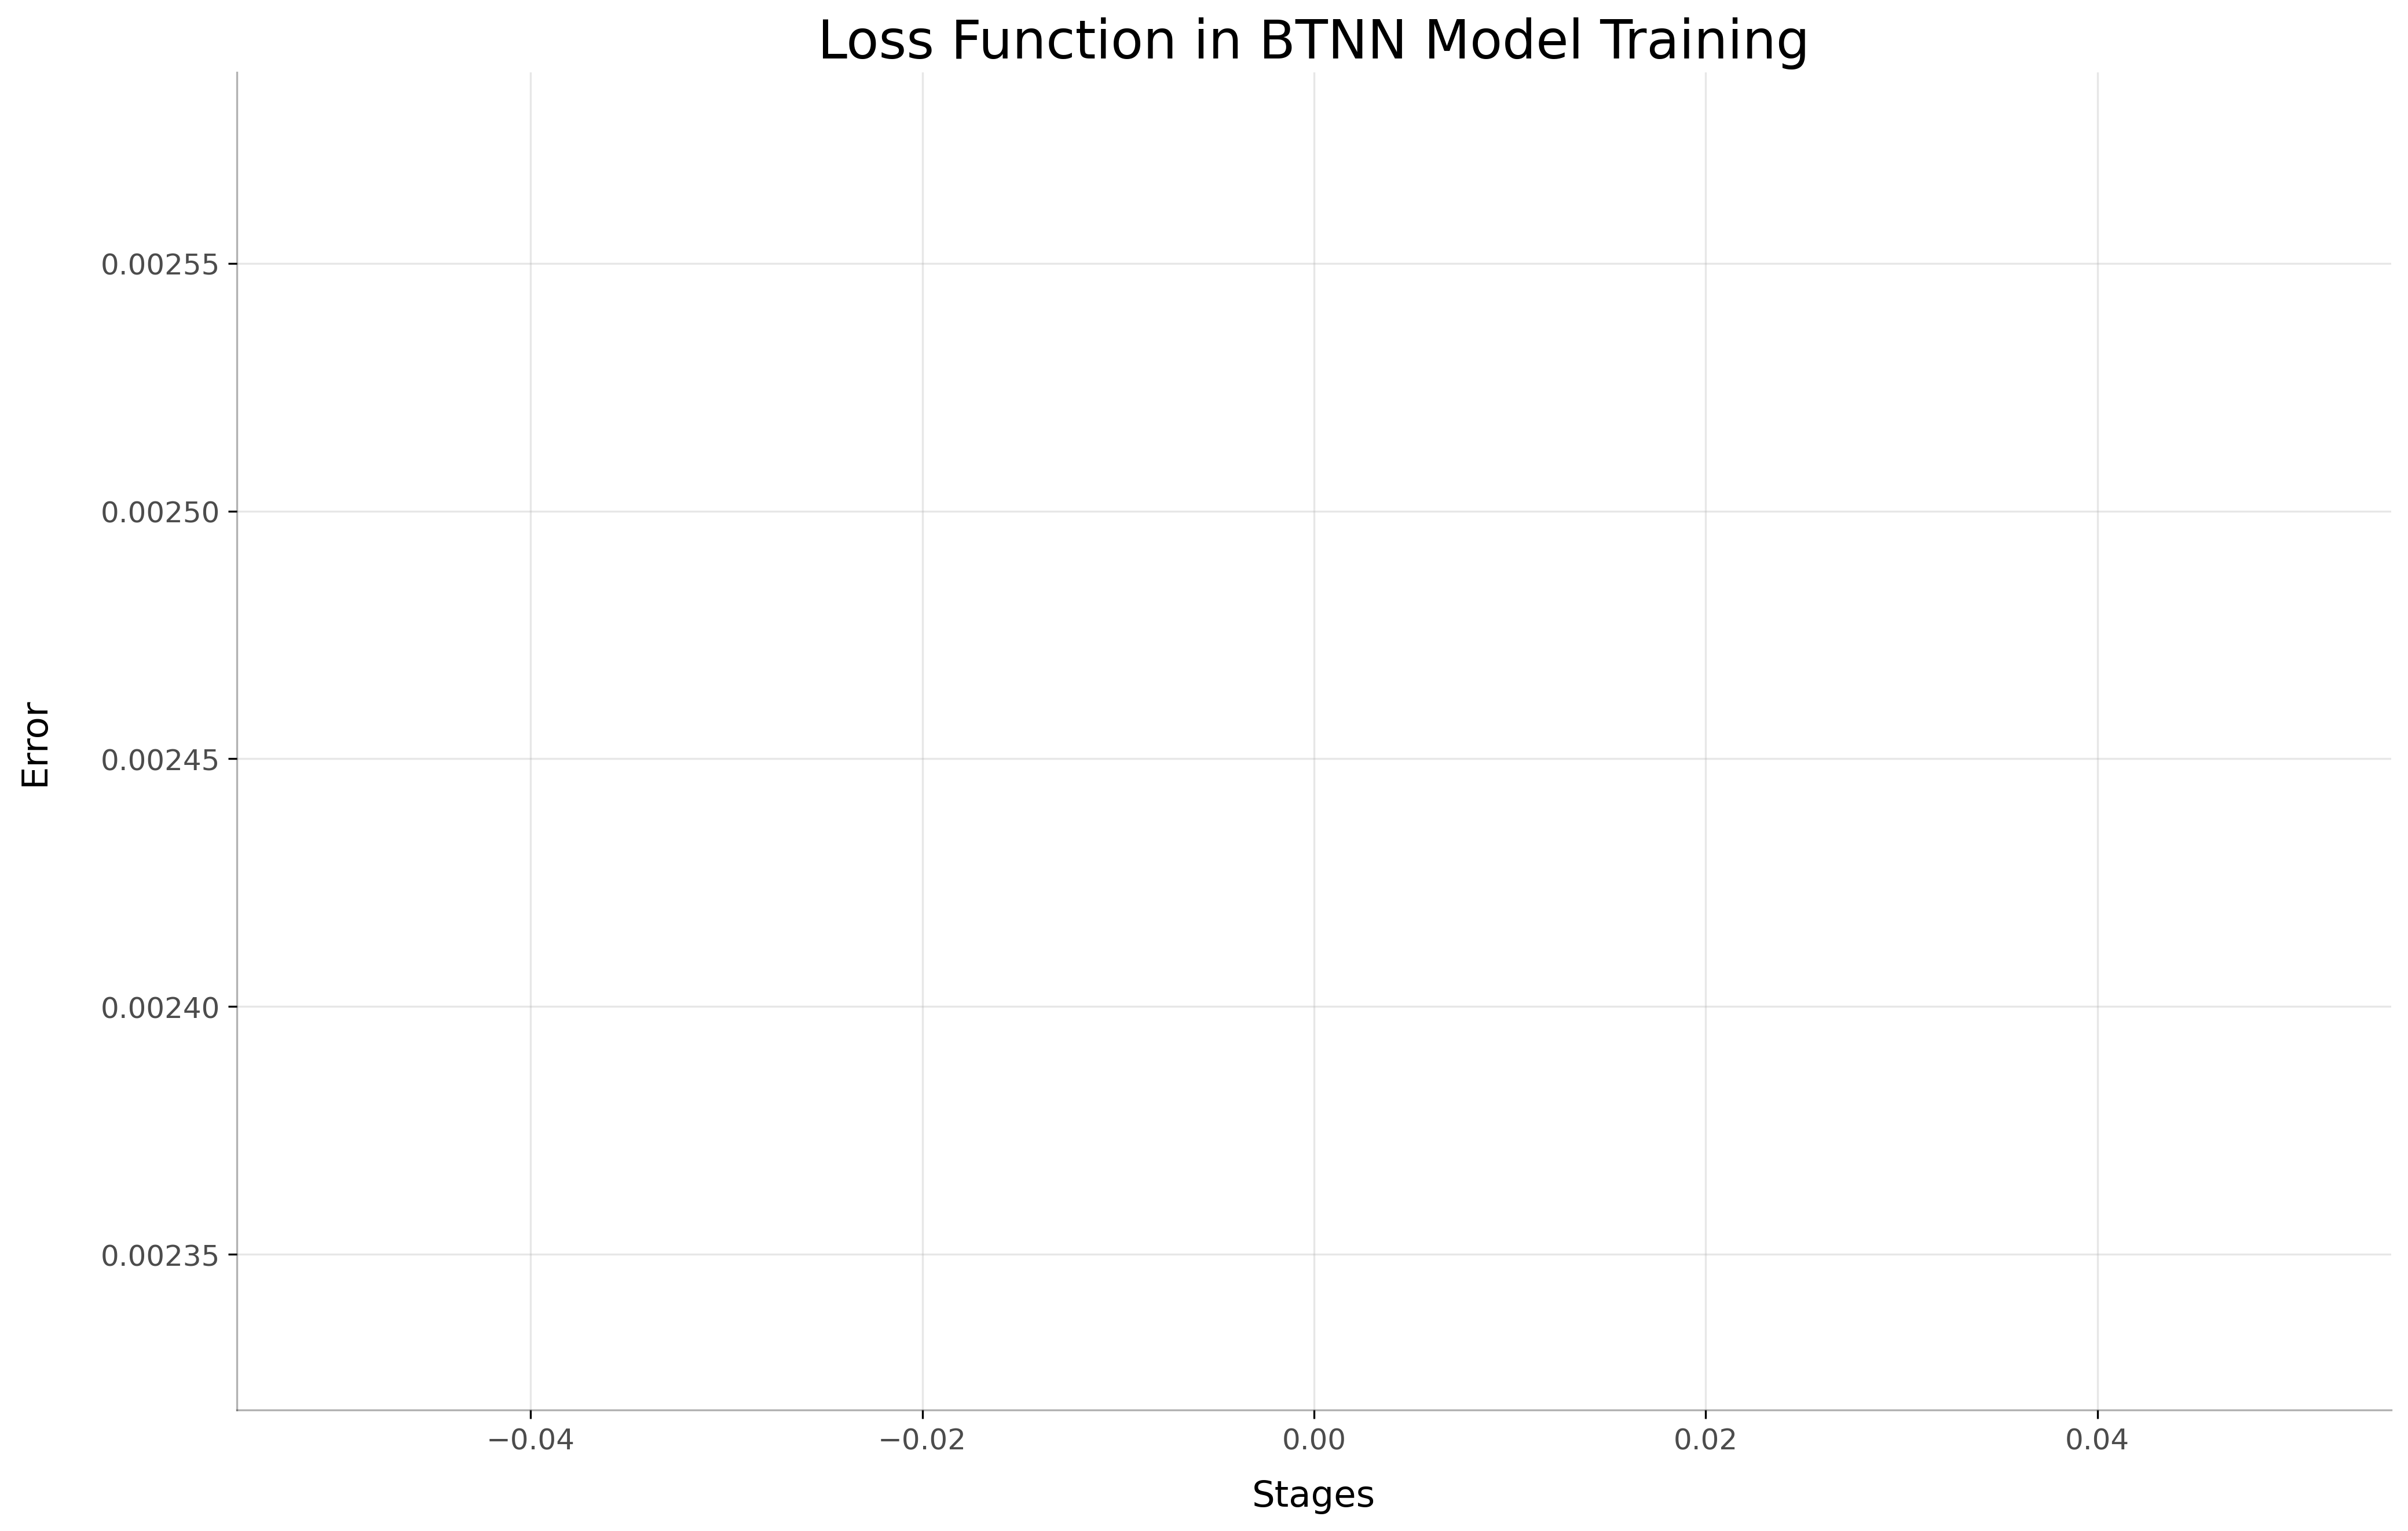

In [29]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 300)
plt.plot(loss_arr[0,:], loss_arr[1,:], linewidth = 3, color='tab:red')

# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.xlabel(r"Stages", fontsize=15, labelpad=10)
plt.ylabel(r"Error", fontsize=15, labelpad=20)
plt.title("Loss Function in BTNN Model Training", fontsize=22)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.savefig('BTNN_loss.pdf', dpi=1200)
plt.show()

(51, 10)
(51, 9)
(51, 8)
(51, 7)
(51, 6)
(51, 5)
(51, 4)
(51, 3)
(51, 2)
(51, 1)


<Figure size 640x480 with 0 Axes>

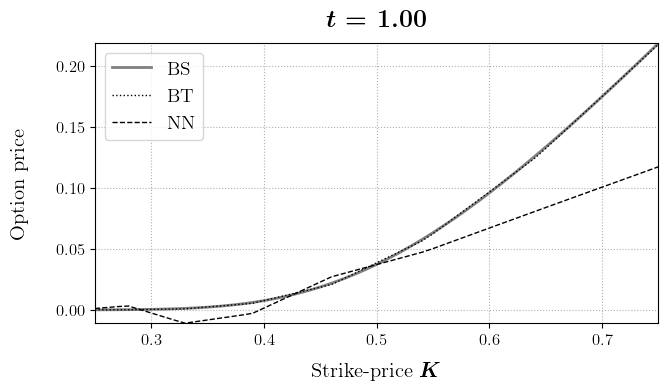

In [30]:
##%% Plot results

# LaTeX rendering for text in plots
plt.rc('text', usetex=True)
plt.rc('font', family='Verdana')

# figure options
plt.figure()
plt.figure(figsize = (16,8))

# time values at which to examine density
valueTimes = [T] #[t_low, T_max/3, 2*T_max/3, T_max]

# vector of t and S values for plotting
K_plot = np.linspace(K_min, K_max, n_plot)

for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    optionValue = BSEurPut(S0, t0, K_plot, T, r, sig) 

    # calculate BT option prices
    BT_optionValue = [xIBT.evalEurPut(Kv) for Kv in K_plot] 
    
    # compute NN option prices
    fitted_optionValue = model(tf.Variable(K_plot.reshape([-1,1]),
                                           dtype=tf.float64)) 
    
    # plot histogram of simulated process values and overlay estimated density
    plt.plot(K_plot, optionValue, color = 'gray', label='BS', 
             linewidth = 2)
    plt.plot(K_plot, BT_optionValue, color = 'k', label='BT', 
             linewidth = 1, linestyle=':')
    plt.plot(K_plot, fitted_optionValue.numpy().flatten(), color = 'k', 
             label='NN', linewidth = 1, linestyle='--')    
    
    # subplot options
    plt.ylim(ymin=min(np.min(optionValue),np.min(fitted_optionValue)), 
             ymax=max(np.max(optionValue),np.max(fitted_optionValue))) # K_max?
    plt.xlim(xmin=K_min, xmax=K_max)
    plt.xlabel(r"Strike-price \boldmath{$K$}", fontsize=15, labelpad=10)
    plt.ylabel(r"Option price", fontsize=15, labelpad=20)
    plt.title(r"\boldmath{$t$}\textbf{ = %.2f}"%(curr_t), fontsize=18, y=1.03)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(linestyle=':')
    
    if i == 0:
        plt.legend(loc='upper left', prop={'size': 14})

# adjust space between subplots
# plt.subplots_adjust(wspace=0.3, hspace=0.4);
plt.savefig('BT_option_prices.pdf', dpi=1200)

(51, 10)
(51, 9)
(51, 8)
(51, 7)
(51, 6)
(51, 5)
(51, 4)
(51, 3)
(51, 2)
(51, 1)


<Figure size 640x480 with 0 Axes>

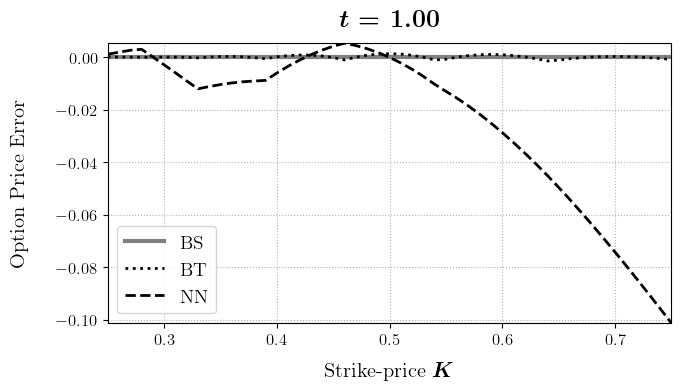

In [31]:
# теперь нарисуем абсолютную ошибку модели CRR и нейросетевой модели 

##%% Plot results

# LaTeX rendering for text in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# figure options
plt.figure()
plt.figure(figsize = (16,8))

# time values at which to examine density
valueTimes = [T] #[t_low, T_max/3, 2*T_max/3, T_max]

# vector of K values for plotting
K_plot = np.linspace(K_min, K_max, n_plot)

for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    optionValue = BSEurPut(S0, t0, K_plot, T, r, sig) 

    # calculate BT option prices
    BT_optionValue = [xIBT.evalEurPut(Kv) for Kv in K_plot] 
    BT_optionValueErr = np.array(BT_optionValue) - optionValue
    
    # compute normalized density at all x values to plot and current t value
    # t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
    fitted_optionValue = model(tf.Variable(K_plot.reshape([-1,1]),dtype=tf.float64)) 
    fitted_optionValueErr = fitted_optionValue.numpy().flatten() - optionValue
    
    # plot histogram of simulated process values and overlay estimated density
#    plt.plot(K_plot, optionValue, color = 'b', label='Analytical Solution', linewidth = 3, linestyle=':')
    plt.plot(K_plot, np.zeros_like(K_plot), color = 'gray', 
             label='BS', linewidth = 3)
    plt.plot(K_plot, BT_optionValueErr, color = 'k', 
             label='BT', linewidth = 2, linestyle=':')
    plt.plot(K_plot, fitted_optionValueErr, color = 'k', 
             label='NN', linewidth = 2, linestyle='--')    
    
    # subplot options
    plt.ylim(ymin=min(np.min(BT_optionValueErr),np.min(fitted_optionValueErr)), 
             ymax=max(np.max(BT_optionValueErr),np.max(fitted_optionValueErr)))
    plt.xlim(xmin=K_min, xmax=K_max)
    plt.xlabel(r"Strike-price \boldmath{$K$}", fontsize=15, labelpad=10)
    plt.ylabel(r"Option Price Error", fontsize=15, labelpad=20)
    plt.title(r"\boldmath{$t$}\textbf{ = %.2f}"%(curr_t), fontsize=18, y=1.03)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(linestyle=':')
    
    if i == 0:
        plt.legend(loc='lower left', prop={'size': 14})

# adjust space between subplots
#plt.subplots_adjust(wspace=0.3, hspace=0.4);
plt.savefig('BT_option_price_err.pdf', dpi=1200)

In [32]:
# evaluate model quality - MSE,MAE,R2 

mMAE = np.sum(np.abs(optionValue - fitted_optionValue))/n_plot
mMSE = np.sum((optionValue - fitted_optionValue)**2)/n_plot
mR2 = 1 - np.sum((optionValue - fitted_optionValue)**2)/n_plot/np.var(optionValue)
mMSE,mMAE,mR2

(np.float64(0.34946389839720937),
 np.float64(3.2613405373242252),
 np.float64(-73.8381955072972))

In [33]:
##%% Error heatmaps - value function
# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_plot)
t_plot = np.linspace(t_low, T_max, n_plot)

# compute option price for each (t,S) pair
option_value_mesh = np.zeros([n_plot, n_plot])

for i in range(n_plot):
    for j in range(n_plot):    
        option_value_mesh[j,i] = HSCall(S_plot[j], t_plot[i], K_max, T_max, r, lamb)

NameError: name 'S_low' is not defined

In [ ]:
# compute model-implied option price for each (t,S) pair
t_mesh, S_mesh = np.meshgrid(t_plot, S_plot)

t_plot2 = np.reshape(t_mesh, [n_plot**2,1])
S_plot2 = np.reshape(S_mesh, [n_plot**2,1])

fitted_option_value = model(t_plot2, S_plot2, T_max*np.ones_like(t_plot2), K_max*np.ones_like(S_plot2)) 
fitted_option_value_mesh = np.reshape(fitted_option_value, [n_plot, n_plot])

In [ ]:
# PLOT ABSOLUTE ERROR
plt.figure()
plt.figure(figsize = (8,6))

plt.pcolormesh(t_mesh, S_mesh, np.abs(option_value_mesh - fitted_option_value_mesh), 
               shading='auto', cmap = "rainbow")

# plot options
plt.colorbar()
plt.title("Absolute Error of DGM Estimate", fontsize=20)
plt.ylabel(r"Price $S$", fontsize=15, labelpad=10)
plt.xlabel(r"Time $t$", fontsize=15, labelpad=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('HS_abs_err.pdf', dpi=1200)

# PLOT RELATIVE ERROR
plt.figure()
plt.figure(figsize = (8,6))

plt.pcolormesh(t_mesh, S_mesh, np.minimum(np.where(option_value_mesh==0.,1., \
                np.abs(1 - np.divide(fitted_option_value_mesh, option_value_mesh))),1.), 
               shading='auto', cmap = "rainbow")

# plot options
plt.colorbar()
plt.title("Relative Error", fontsize=20)
plt.ylabel("Price", fontsize=15, labelpad=10)
plt.xlabel("Time", fontsize=15, labelpad=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('HS_rel_err.pdf', dpi=1200)
plt.show();

In [ ]:
use('TkAgg')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(t_mesh, S_mesh, option_value_mesh, \
                       rstride=1, cstride=1, linewidth=0.05, cmap=cm.jet, antialiased=False, \
                       edgecolors='gray') # rainbow winter_r coolwarm cool   color='c',

ax.set_xlabel(r'Time $t$', fontsize=14) # , fontsize=18
ax.set_ylabel(r'Price $S$', fontsize=14)
ax.set_zlabel(r'Analytical Option Price', fontsize=14) 
ax.set_title(r'Analytical Option Price Surface', fontsize=16)

# Customize the z axis.
ax.set_zlim(0., option_value_mesh.max())
ax.zaxis.set_major_locator(LinearLocator(11))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.view_init(elev = 20, azim = -130)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
surf.set_clim(0., option_value_mesh.max())
fig.tight_layout()

#fig.set_size_inches(5.5,3.5)
#plt.savefig('HS_option_price.pdf', dpi=1200)
plt.draw()
plt.show()
plt.pause(0.5)

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(t_mesh, S_mesh, fitted_option_value_mesh, \
                       rstride=1, cstride=1, linewidth=0.05, cmap=cm.jet, antialiased=False, \
                       edgecolors='gray') # rainbow winter_r coolwarm cool   color='c',

ax.set_xlabel(r'Time $t$', fontsize=14) # , fontsize=18
ax.set_ylabel(r'Price $S$', fontsize=14)
ax.set_zlabel(r'DGM Option Price', fontsize=14) 
ax.set_title(r'DGM Option Price Surface', fontsize=16)

# Customize the z axis.
ax.set_zlim(fitted_option_value_mesh.min(), fitted_option_value_mesh.max())
ax.zaxis.set_major_locator(LinearLocator(11))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.view_init(elev = 20, azim = -60)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
surf.set_clim(fitted_option_value_mesh.min(), fitted_option_value_mesh.max())
fig.tight_layout()

#fig.set_size_inches(5.5,3.5)
#plt.savefig('HS_DGM_option_price.pdf', dpi=1200)
plt.draw()
plt.show()
plt.pause(0.5)

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface.
surf = ax.plot_surface(t_mesh, S_mesh, np.abs(option_value_mesh - fitted_option_value_mesh), \
                       rstride=1, cstride=1, linewidth=0.05, cmap=cm.jet, antialiased=False, \
                       edgecolors='gray') # rainbow winter_r coolwarm cool   color='c',

ax.set_xlabel(r'Time $t$', fontsize=14) # , fontsize=18
ax.set_ylabel(r'Price $S$', fontsize=14)
ax.set_zlabel(r'Absolute Option Price Error', fontsize=14) 
ax.set_title(r'Absolute Error Surface of DGM Option Price Estimate', fontsize=16)

# Customize the z axis.
ax.set_zlim(0., (np.abs(option_value_mesh - fitted_option_value_mesh)).max())
ax.zaxis.set_major_locator(LinearLocator(11))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.view_init(elev = 20, azim = -120)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
surf.set_clim(0., (np.abs(option_value_mesh - fitted_option_value_mesh)).max())
fig.tight_layout()

#fig.set_size_inches(5.5,3.5)
plt.savefig('HS_2_abs_err_3d.pdf', dpi=1200)
plt.draw()
plt.show()
plt.pause(1.)